# Testing Model SVM untuk Digit Recognition

Notebook ini akan:
1. Load model SVM/Keras yang sudah di-train
2. Membaca gambar `aaa.jpg`
3. Mengekstrak setiap digit dari gambar
4. Memprediksi setiap digit menggunakan model

In [1]:
# Import library yang diperlukan
import numpy as np
import cv2
import matplotlib.pyplot as plt
import joblib
import json
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import os

print("Library berhasil di-import!")
print(f"TensorFlow version: {tf.__version__}")

Library berhasil di-import!
TensorFlow version: 2.19.1


In [2]:
# Konfigurasi
IMAGE_PATH = 'a.jpg'
MODEL_TYPE = 'keras'  # 'svm' atau 'keras'
SVM_MODEL_PATH = 'digit_svm_model.pkl'
SCALER_PATH = 'feature_scaler.pkl'
KERAS_MODEL_PATH = 'digit_svm_model.keras'
IMG_SIZE = 28

print(f"Image path: {IMAGE_PATH}")
print(f"Model type: {MODEL_TYPE}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")

Image path: a.jpg
Model type: keras
Image size: 28x28


## Load Model

In [3]:
# Load model sesuai pilihan
if MODEL_TYPE == 'svm':
    if os.path.exists(SVM_MODEL_PATH):
        print(f"Loading SVM model dari {SVM_MODEL_PATH}...")
        model = joblib.load(SVM_MODEL_PATH)
        print("✓ SVM model berhasil di-load!")
        
        # Load scaler untuk SVM
        if os.path.exists(SCALER_PATH):
            scaler = joblib.load(SCALER_PATH)
            print("✓ Feature scaler berhasil di-load!")
        else:
            print("⚠️  Scaler tidak ditemukan, akan menggunakan features tanpa scaling")
            scaler = None
    else:
        print(f"❌ Model SVM tidak ditemukan di {SVM_MODEL_PATH}")
        print("Silakan jalankan notebook training terlebih dahulu!")
        
elif MODEL_TYPE == 'keras':
    if os.path.exists(KERAS_MODEL_PATH):
        print(f"Loading Keras model dari {KERAS_MODEL_PATH}...")
        model = keras.models.load_model(KERAS_MODEL_PATH)
        print("✓ Keras model berhasil di-load!")
        
        # Load scaler untuk Keras (jika model di-training dengan features)
        if os.path.exists(SCALER_PATH):
            scaler = joblib.load(SCALER_PATH)
            print("✓ Feature scaler berhasil di-load!")
            print("ℹ️  Model menggunakan HOG + Geometrical features")
        else:
            print("ℹ️  Model menggunakan raw pixel values (CNN)")
            scaler = None
        
        print("\nModel summary:")
        model.summary()
    else:
        print(f"❌ Model Keras tidak ditemukan di {KERAS_MODEL_PATH}")
        print("Silakan jalankan notebook training terlebih dahulu!")

Loading Keras model dari digit_svm_model.keras...
✓ Keras model berhasil di-load!
✓ Feature scaler berhasil di-load!
ℹ️  Model menggunakan HOG + Geometrical features

Model summary:


Model: "digit_svm_features_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        39,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,520 (966.88 KB)

 Trainable params: 82,250 (321.29 KB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 164,502 (642.59 KB)

## Load dan Preprocessing Gambar

## Fungsi Ekstraksi Fitur (HOG + Geometrical)

In [4]:
def extract_hog_features(image):
    """Ekstraksi HOG features"""
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    
    hog_features = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False,
        feature_vector=True
    )
    return hog_features


def extract_geometrical_features(image):
    """Ekstraksi Geometrical features"""
    if image.max() <= 1.0:
        binary = (image * 255).astype(np.uint8)
    else:
        binary = image.astype(np.uint8)
    
    _, binary = cv2.threshold(binary, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return np.zeros(10)
    
    main_contour = max(contours, key=cv2.contourArea)
    
    # Area & Perimeter
    area = cv2.contourArea(main_contour)
    perimeter = cv2.arcLength(main_contour, True)
    
    # Bounding box
    x, y, w, h = cv2.boundingRect(main_contour)
    aspect_ratio = float(w) / h if h != 0 else 0
    
    # Extent & Solidity
    rect_area = w * h
    extent = float(area) / rect_area if rect_area != 0 else 0
    
    hull = cv2.convexHull(main_contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area != 0 else 0
    
    # Equivalent Diameter & Circularity
    equiv_diameter = np.sqrt(4 * area / np.pi)
    circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter != 0 else 0
    
    # Hu Moments
    moments = cv2.moments(main_contour)
    hu_moments = cv2.HuMoments(moments).flatten()
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    
    geo_features = np.array([
        area / 1000.0,
        perimeter / 100.0,
        aspect_ratio,
        extent,
        solidity,
        equiv_diameter / 10.0,
        circularity
    ])
    
    geo_features = np.concatenate([geo_features, hu_moments[:3]])
    return geo_features


def extract_combined_features(image):
    """Ekstraksi kombinasi HOG + Geometrical features"""
    hog_feat = extract_hog_features(image)
    geo_feat = extract_geometrical_features(image)
    combined = np.concatenate([hog_feat, geo_feat])
    return combined


print("✓ Fungsi ekstraksi fitur siap digunakan!")

✓ Fungsi ekstraksi fitur siap digunakan!


Loading gambar dari a.jpg...
✓ Gambar berhasil di-load!
Ukuran gambar: (57, 450, 3)


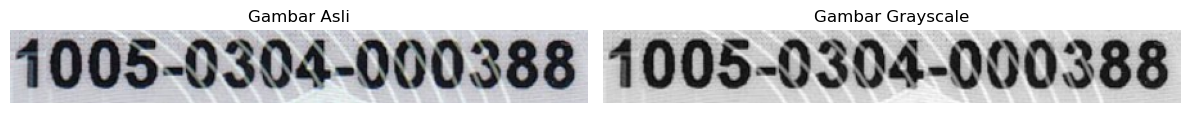

In [5]:
# Load gambar
if not os.path.exists(IMAGE_PATH):
    print(f"❌ Gambar tidak ditemukan: {IMAGE_PATH}")
    print("Pastikan file aaa.jpg ada di direktori yang sama dengan notebook ini.")
else:
    print(f"Loading gambar dari {IMAGE_PATH}...")
    img_original = cv2.imread(IMAGE_PATH)
    img_gray = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)
    
    print(f"✓ Gambar berhasil di-load!")
    print(f"Ukuran gambar: {img_original.shape}")
    
    # Tampilkan gambar asli
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
    plt.title('Gambar Asli')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_gray, cmap='gray')
    plt.title('Gambar Grayscale')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## Ekstraksi Digit dari Gambar

Mengekstrak digit dari gambar...

Pilihan mode:
  'lembut' - Preprocessing minimal, cocok untuk gambar berkualitas baik
  'sedang' - Preprocessing seimbang (default)
  'keras'  - Preprocessing agresif, cocok untuk gambar dengan noise

🟢 Mode: LEMBUT - Preprocessing minimal
✓ Ditemukan 28 digit!


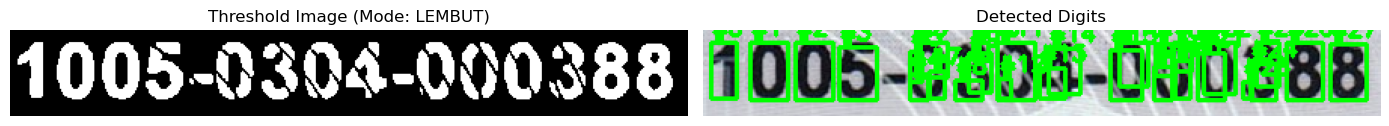


Detail setiap digit:
  Digit #0: Position (5, 8), Size 17x37
  Digit #1: Position (31, 8), Size 25x38
  Digit #2: Position (61, 8), Size 25x38
  Digit #3: Position (90, 11), Size 25x35
  Digit #4: Position (137, 29), Size 12x17
  Digit #5: Position (137, 14), Size 8x20
  Digit #6: Position (141, 8), Size 21x23
  Digit #7: Position (150, 27), Size 10x18
  Digit #8: Position (167, 33), Size 18x13
  Digit #9: Position (176, 15), Size 15x26
  Digit #10: Position (179, 8), Size 10x12
  Digit #11: Position (195, 8), Size 25x38
  Digit #12: Position (196, 32), Size 8x13
  Digit #13: Position (223, 25), Size 17x20
  Digit #14: Position (229, 12), Size 21x30
  Digit #15: Position (270, 13), Size 21x33
  Digit #16: Position (276, 8), Size 19x29
  Digit #17: Position (299, 24), Size 12x22
  Digit #18: Position (300, 9), Size 11x21
  Digit #19: Position (312, 8), Size 12x19
  Digit #20: Position (313, 20), Size 10x25
  Digit #21: Position (328, 15), Size 18x31
  Digit #22: Position (332, 8), Size

In [6]:
def extract_digits(image_gray, threshold_mode='sedang'):
    """
    Ekstrak digit-digit dari gambar menggunakan contour detection
    Args:
        image_gray: gambar grayscale
        threshold_mode: 'lembut', 'sedang', atau 'keras' - tingkat agresivitas preprocessing
    Returns:
        digits: list of (digit_image, bounding_box)
    """
    # Preprocessing dengan adaptive thresholding untuk hasil lebih baik
    # Gunakan Otsu's thresholding untuk threshold otomatis
    _, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Morphological operations dengan tingkat agresivitas berbeda
    if threshold_mode == 'lembut':
        # Mode LEMBUT - minimal processing, cocok untuk gambar berkualitas baik
        print("🟢 Mode: LEMBUT - Preprocessing minimal")
        
        # Kernel kecil
        kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
        
        # Opening ringan untuk remove noise
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_vertical)
        
        # Tidak ada erosi
        erode_iterations = 0
        
        # Filter size lebih permisif
        min_width = 5
        min_height = 10
        max_aspect_ratio = 2.0
        split_threshold = 1.2
        split_min_width = 50
        
    elif threshold_mode == 'keras':
        # Mode KERAS - aggressive processing, cocok untuk gambar dengan noise atau digit menempel
        print("🔴 Mode: KERAS - Preprocessing agresif")
        
        # Kernel besar
        kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 7))
        kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 1))
        
        # Opening kuat
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_vertical)
        
        # Erosi kuat untuk memisahkan digit yang sangat berdekatan
        kernel_erode = np.ones((3, 3), np.uint8)
        thresh = cv2.erode(thresh, kernel_erode, iterations=2)
        
        # Filter size lebih ketat
        min_width = 10
        min_height = 20
        max_aspect_ratio = 1.2
        split_threshold = 0.7
        split_min_width = 30
        
    else:  # 'sedang' (default)
        # Mode SEDANG - balanced processing
        print("🟡 Mode: SEDANG - Preprocessing seimbang")
        
        # Kernel medium
        kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
        
        # Opening medium
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_vertical)
        
        # Erosi sedang
        kernel_erode = np.ones((2, 2), np.uint8)
        thresh = cv2.erode(thresh, kernel_erode, iterations=1)
        
        # Filter size medium
        min_width = 8
        min_height = 15
        max_aspect_ratio = 1.5
        split_threshold = 0.8
        split_min_width = 35
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter dan sort contours
    digit_contours = []
    img_height = image_gray.shape[0]
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter berdasarkan ukuran dan aspect ratio
        aspect_ratio = w / float(h) if h > 0 else 0
        
        # Filter: minimum size dan aspect ratio reasonable untuk digit
        if (w > min_width and h > min_height and  # Minimum size
            h < img_height * 0.9 and  # Tidak terlalu tinggi
            aspect_ratio < max_aspect_ratio):  # Tidak terlalu lebar
            digit_contours.append((x, y, w, h, contour))
    
    # Cek apakah ada digit yang terlalu lebar (mungkin gabungan 2 digit)
    processed_contours = []
    for x, y, w, h, contour in digit_contours:
        aspect_ratio = w / float(h)
        
        # Jika aspect ratio terlalu besar, mungkin 2 digit bergabung
        if aspect_ratio > split_threshold and w > split_min_width:
            # Split menjadi 2 digit
            mid_x = x + w // 2
            w_half = w // 2
            
            # Digit kiri
            processed_contours.append((x, y, w_half, h, None))
            # Digit kanan
            processed_contours.append((mid_x, y, w_half, h, None))
            print(f"⚠️  Split digit lebar di x={x} menjadi 2 digit")
        else:
            processed_contours.append((x, y, w, h, contour))
    
    # Sort dari kiri ke kanan
    processed_contours = sorted(processed_contours, key=lambda x: x[0])
    
    # Extract digit images
    digits = []
    for i, (x, y, w, h, contour) in enumerate(processed_contours):
        # Tambahkan padding
        padding = 3
        x_start = max(0, x - padding)
        y_start = max(0, y - padding)
        x_end = min(image_gray.shape[1], x + w + padding)
        y_end = min(image_gray.shape[0], y + h + padding)
        
        # Crop digit - TIDAK INVERSI, angka hitam background putih
        digit_roi = image_gray[y_start:y_end, x_start:x_end]
        
        digits.append({
            'image': digit_roi,
            'bbox': (x, y, w, h),
            'index': i
        })
    
    return digits, thresh

# Ekstrak digits dengan mode yang bisa dipilih
print("Mengekstrak digit dari gambar...")
print("\nPilihan mode:")
print("  'lembut' - Preprocessing minimal, cocok untuk gambar berkualitas baik")
print("  'sedang' - Preprocessing seimbang (default)")
print("  'keras'  - Preprocessing agresif, cocok untuk gambar dengan noise\n")

# PILIH MODE DI SINI: 'lembut', 'sedang', atau 'keras'
THRESHOLD_MODE = 'lembut' # UBAH DISINI YAAA

digits, thresh_img = extract_digits(img_gray, threshold_mode=THRESHOLD_MODE)
print(f"✓ Ditemukan {len(digits)} digit!")

# Tampilkan threshold image dan bounding boxes
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.imshow(thresh_img, cmap='gray')
plt.title(f'Threshold Image (Mode: {THRESHOLD_MODE.upper()})')
plt.axis('off')

plt.subplot(1, 2, 2)
img_with_boxes = img_original.copy()
for digit in digits:
    x, y, w, h = digit['bbox']
    cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(img_with_boxes, f"#{digit['index']}", (x, y-5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
plt.title('Detected Digits')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\nDetail setiap digit:")
for digit in digits:
    x, y, w, h = digit['bbox']
    print(f"  Digit #{digit['index']}: Position ({x}, {y}), Size {w}x{h}")

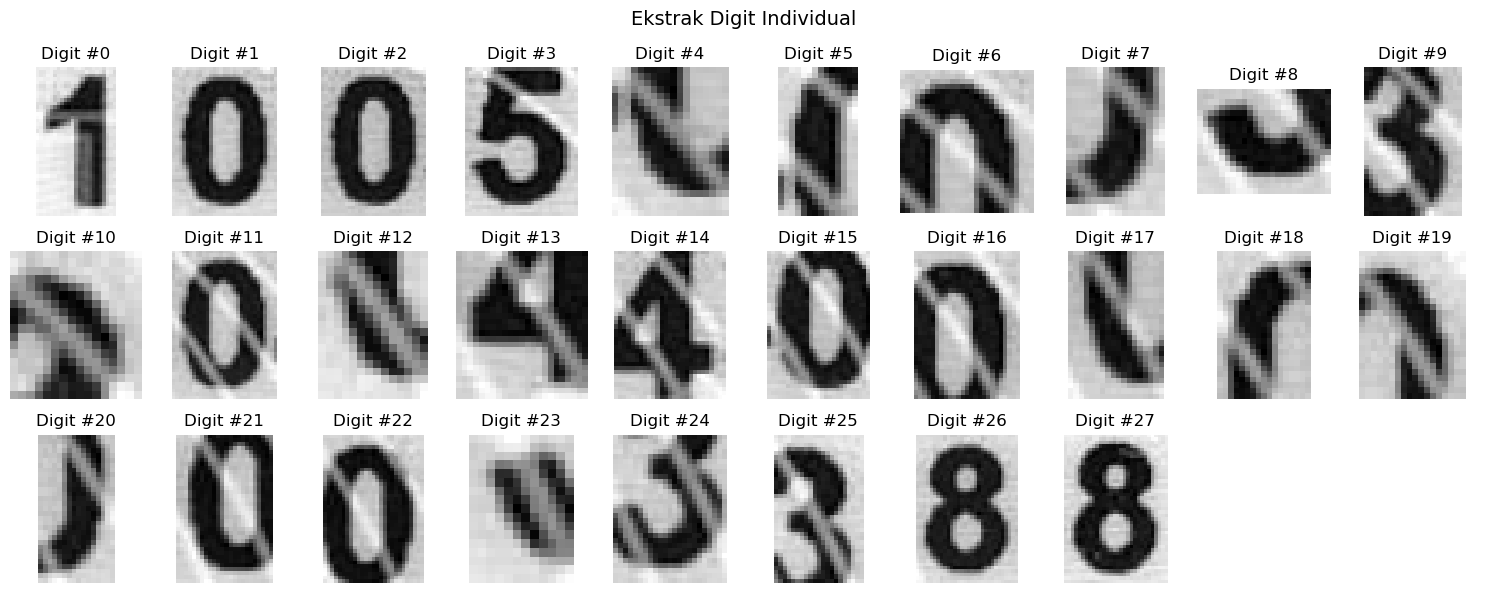

In [7]:
# Visualisasi setiap digit yang diekstrak
if len(digits) > 0:
    cols = min(len(digits), 10)
    rows = (len(digits) - 1) // 10 + 1
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 2*rows))
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = list(axes)
    else:
        axes = axes.flatten()
    
    for i, digit in enumerate(digits):
        axes[i].imshow(digit['image'], cmap='gray')
        axes[i].set_title(f"Digit #{i}")
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(digits), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Ekstrak Digit Individual', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada digit yang terdeteksi!")

## Preprocessing Digit untuk Prediksi

In [8]:
def preprocess_digit_for_prediction(digit_img, img_size=28):
    """
    Preprocessing digit untuk prediksi model
    Args:
        digit_img: gambar digit grayscale (angka hitam, background putih)
        img_size: ukuran target
    Returns:
        processed image
    """
    # Resize dengan mempertahankan aspect ratio
    h, w = digit_img.shape
    
    # Buat square image dengan padding
    if h > w:
        # Tinggi lebih besar
        new_h = img_size
        new_w = int(w * img_size / h)
    else:
        # Lebar lebih besar atau sama
        new_w = img_size
        new_h = int(h * img_size / w)
    
    # Resize
    resized = cv2.resize(digit_img, (new_w, new_h))
    
    # Buat canvas square dengan background putih (255)
    canvas = np.ones((img_size, img_size), dtype=np.uint8) * 255
    
    # Tempatkan di tengah
    y_offset = (img_size - new_h) // 2
    x_offset = (img_size - new_w) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    
    # Normalize
    canvas = canvas / 255.0
    
    return canvas

# Preprocess semua digits
print("Preprocessing digit untuk prediksi...")
processed_digits = []

for digit in digits:
    processed = preprocess_digit_for_prediction(digit['image'], IMG_SIZE)
    processed_digits.append(processed)

processed_digits = np.array(processed_digits)
print(f"✓ Preprocessing selesai!")
print(f"Shape: {processed_digits.shape}")

Preprocessing digit untuk prediksi...
✓ Preprocessing selesai!
Shape: (28, 28, 28)


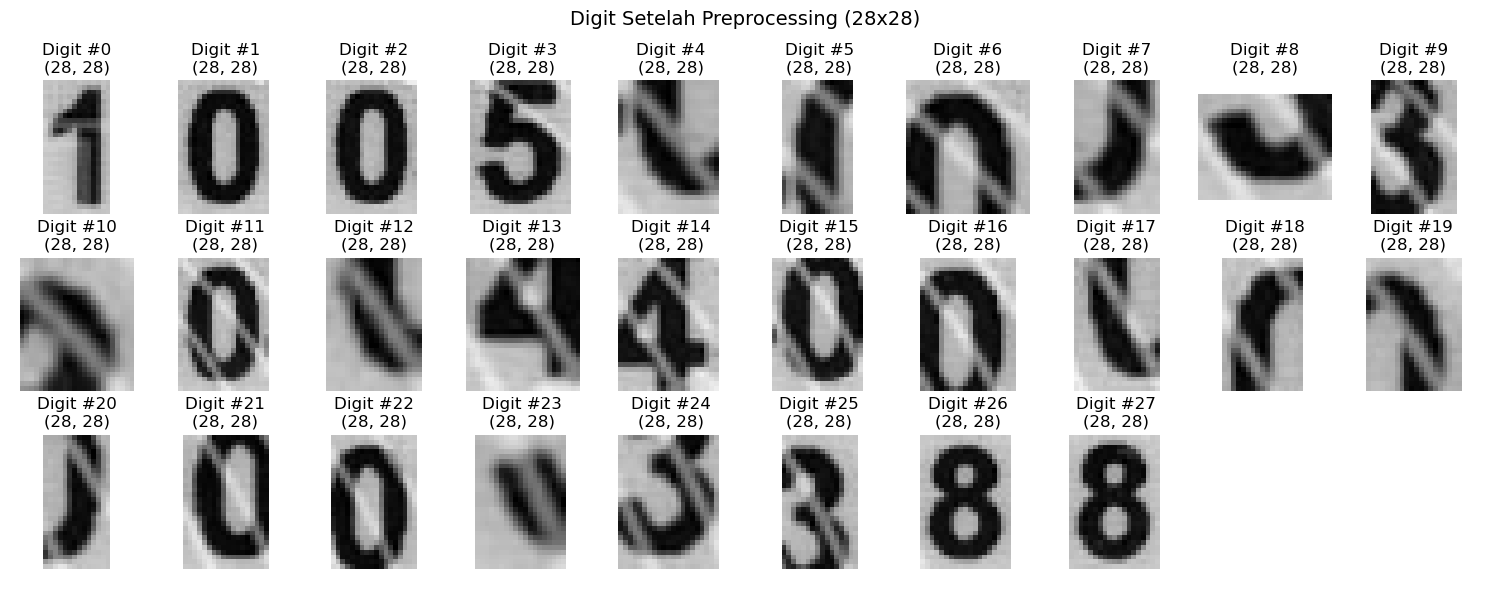

In [9]:
# Visualisasi hasil preprocessing
if len(processed_digits) > 0:
    cols = min(len(processed_digits), 10)
    rows = (len(processed_digits) - 1) // 10 + 1
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 2*rows))
    if rows == 1:
        axes = [axes] if len(processed_digits) == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, proc_digit in enumerate(processed_digits):
        if rows == 1 and len(processed_digits) == 1:
            ax = axes[0]
        elif rows == 1:
            ax = axes[i]
        else:
            ax = axes[i]
        ax.imshow(proc_digit, cmap='gray')
        ax.set_title(f"Digit #{i}\n{proc_digit.shape}")
        ax.axis('off')
    
    # Hide unused subplots
    if rows > 1 or len(processed_digits) > 1:
        for i in range(len(processed_digits), len(axes)):
            axes[i].axis('off')
    
    plt.suptitle('Digit Setelah Preprocessing (28x28)', fontsize=14)
    plt.tight_layout()
    plt.show()

## Prediksi Digit menggunakan Model

In [10]:
def predict_digits(processed_digits, model, model_type='keras'):
    """
    Prediksi digit menggunakan model
    Args:
        processed_digits: array of preprocessed digits
        model: trained model
        model_type: 'svm' atau 'keras'
    Returns:
        predictions, probabilities
    """
    if len(processed_digits) == 0:
        return [], []
    
    # Cek apakah model menggunakan features atau raw pixels
    if scaler is not None:
        # Model menggunakan HOG + Geometrical features
        print("Mengekstrak fitur HOG + Geometrical...")
        features = []
        for digit in processed_digits:
            feat = extract_combined_features(digit)
            features.append(feat)
        features = np.array(features)
        
        # Scale features
        features_scaled = scaler.transform(features)
        
        if model_type == 'svm':
            predictions = model.predict(features_scaled)
            
            # Get decision function as confidence
            decision = model.decision_function(features_scaled)
            
            # Convert to probabilities using softmax
            exp_decision = np.exp(decision - np.max(decision, axis=1, keepdims=True))
            probabilities = exp_decision / np.sum(exp_decision, axis=1, keepdims=True)
            
        elif model_type == 'keras':
            # Predict dengan features
            probabilities = model.predict(features_scaled, verbose=0)
            predictions = np.argmax(probabilities, axis=1)
    
    else:
        # Model menggunakan raw pixels (CNN)
        if model_type == 'svm':
            # Flatten untuk SVM
            flattened = processed_digits.reshape(len(processed_digits), -1)
            predictions = model.predict(flattened)
            
            # Get decision function as confidence
            decision = model.decision_function(flattened)
            
            # Convert to probabilities using softmax
            exp_decision = np.exp(decision - np.max(decision, axis=1, keepdims=True))
            probabilities = exp_decision / np.sum(exp_decision, axis=1, keepdims=True)
            
        elif model_type == 'keras':
            # Reshape untuk Keras (add channel dimension)
            reshaped = processed_digits.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
            
            # Predict
            probabilities = model.predict(reshaped, verbose=0)
            predictions = np.argmax(probabilities, axis=1)
    
    return predictions, probabilities

# Lakukan prediksi
print("Melakukan prediksi...")
predictions, probabilities = predict_digits(processed_digits, model, MODEL_TYPE)
print(f"✓ Prediksi selesai!")

# Tampilkan hasil
print("\n" + "="*60)
print("HASIL PREDIKSI")
print("="*60)
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    confidence = prob[pred] * 100
    print(f"Digit #{i}: Prediksi = {pred}, Confidence = {confidence:.2f}%")
print("="*60)

Melakukan prediksi...
Mengekstrak fitur HOG + Geometrical...
✓ Prediksi selesai!

HASIL PREDIKSI
Digit #0: Prediksi = 1, Confidence = 100.00%
Digit #1: Prediksi = 0, Confidence = 99.53%
Digit #2: Prediksi = 0, Confidence = 98.13%
Digit #3: Prediksi = 5, Confidence = 100.00%
Digit #4: Prediksi = 9, Confidence = 45.80%
Digit #5: Prediksi = 0, Confidence = 95.44%
Digit #6: Prediksi = 8, Confidence = 99.29%
Digit #7: Prediksi = 4, Confidence = 99.81%
Digit #8: Prediksi = 9, Confidence = 99.85%
Digit #9: Prediksi = 9, Confidence = 37.90%
Digit #10: Prediksi = 8, Confidence = 99.90%
Digit #11: Prediksi = 8, Confidence = 83.61%
Digit #12: Prediksi = 1, Confidence = 99.61%
Digit #13: Prediksi = 4, Confidence = 99.93%
Digit #14: Prediksi = 4, Confidence = 98.51%
Digit #15: Prediksi = 1, Confidence = 93.64%
Digit #16: Prediksi = 8, Confidence = 70.83%
Digit #17: Prediksi = 4, Confidence = 83.42%
Digit #18: Prediksi = 0, Confidence = 60.49%
Digit #19: Prediksi = 9, Confidence = 72.31%
Digit #20: 

## Visualisasi Hasil Prediksi

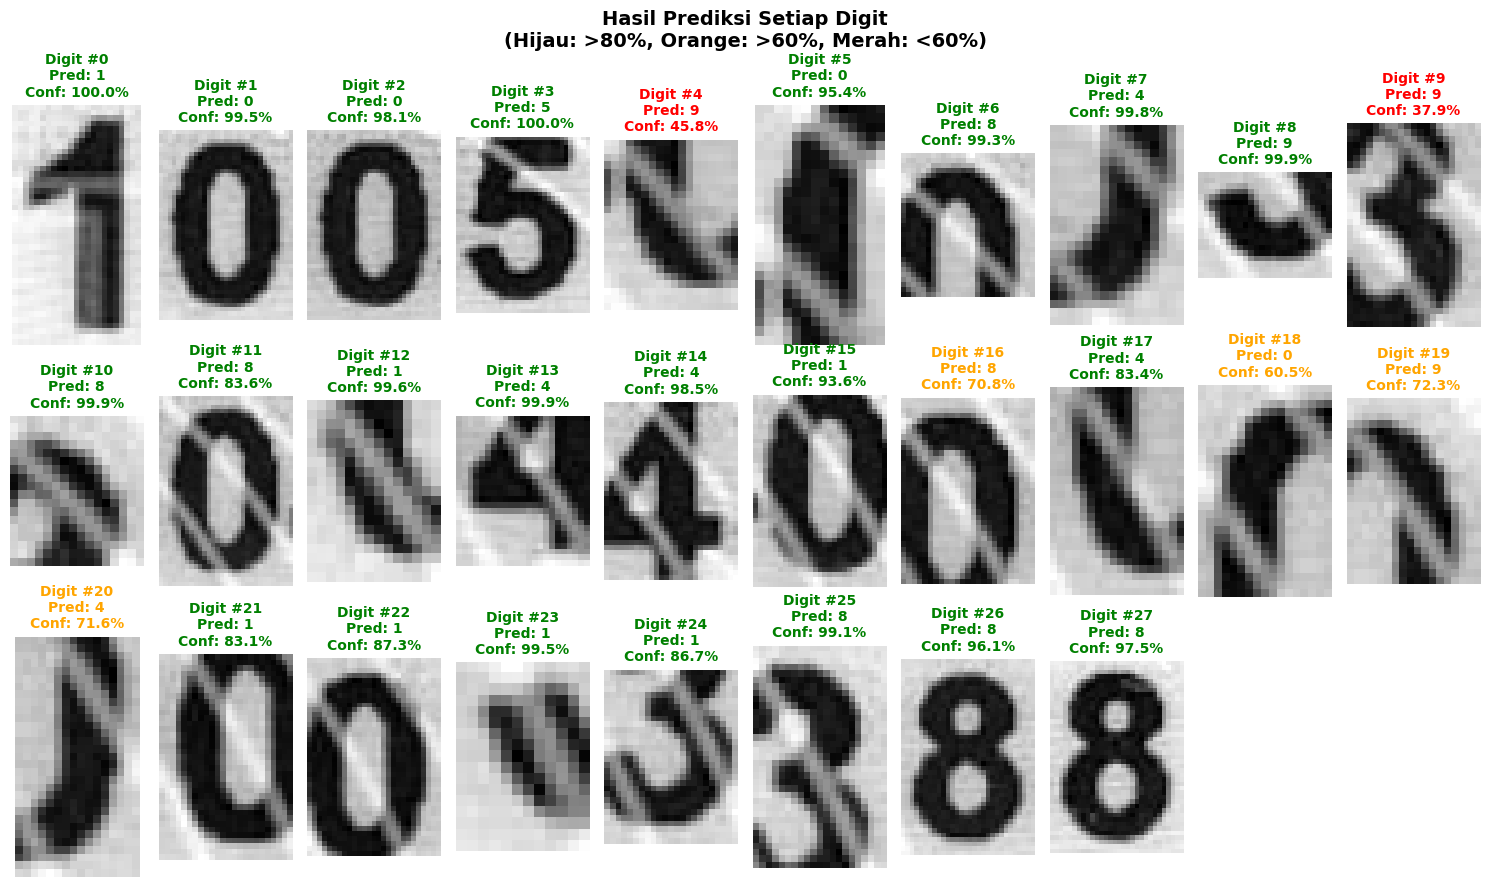

In [11]:
# Visualisasi prediksi dengan digit asli
if len(predictions) > 0:
    cols = min(len(predictions), 10)
    rows = (len(predictions) - 1) // 10 + 1
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = list(axes)
    else:
        axes = axes.flatten()
    
    for i, (digit, pred, prob) in enumerate(zip(digits, predictions, probabilities)):
        ax = axes[i]
            
        ax.imshow(digit['image'], cmap='gray')
        confidence = prob[pred] * 100
        
        # Warna berdasarkan confidence
        color = 'green' if confidence > 80 else 'orange' if confidence > 60 else 'red'
        
        ax.set_title(f"Digit #{i}\nPred: {pred}\nConf: {confidence:.1f}%", 
                     color=color, fontsize=10, fontweight='bold')
        ax.axis('off')
    
    # Hide unused subplots
    if rows > 1 or len(predictions) > 1:
        for i in range(len(predictions), len(axes)):
            axes[i].axis('off')
    
    plt.suptitle('Hasil Prediksi Setiap Digit\n(Hijau: >80%, Orange: >60%, Merah: <60%)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada prediksi untuk ditampilkan!")

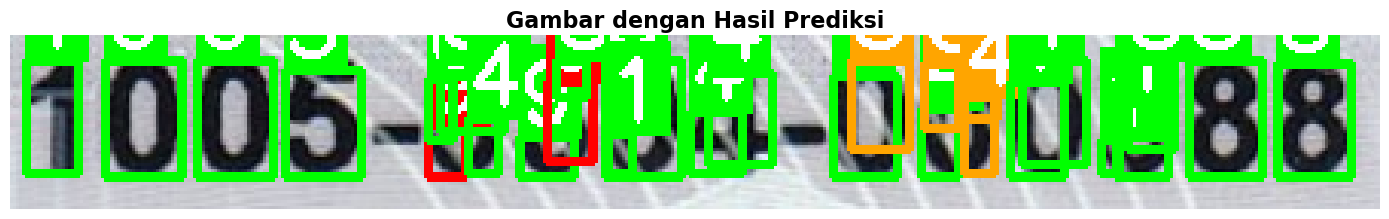


ANGKA YANG TERDETEKSI: 1005908499881441840941111888


In [12]:
# Tampilkan gambar asli dengan hasil prediksi
if len(predictions) > 0:
    img_result = img_original.copy()
    
    for digit, pred, prob in zip(digits, predictions, probabilities):
        x, y, w, h = digit['bbox']
        confidence = prob[pred] * 100
        
        # Warna box berdasarkan confidence
        if confidence > 80:
            color = (0, 255, 0)  # Green
        elif confidence > 60:
            color = (0, 165, 255)  # Orange
        else:
            color = (0, 0, 255)  # Red
        
        # Draw bounding box
        cv2.rectangle(img_result, (x, y), (x+w, y+h), color, 2)
        
        # Draw prediction text
        text = f"{pred}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)[0]
        
        # Background untuk text
        cv2.rectangle(img_result, (x, y-text_size[1]-10), 
                     (x+text_size[0], y), color, -1)
        
        # Text
        cv2.putText(img_result, text, (x, y-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
    
    plt.figure(figsize=(14, 8))
    plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    plt.title('Gambar dengan Hasil Prediksi', fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Gabungkan hasil prediksi menjadi satu angka
    predicted_number = ''.join([str(p) for p in predictions])
    print("\n" + "="*60)
    print(f"ANGKA YANG TERDETEKSI: {predicted_number}")
    print("="*60)

## Detail Probabilitas Setiap Digit

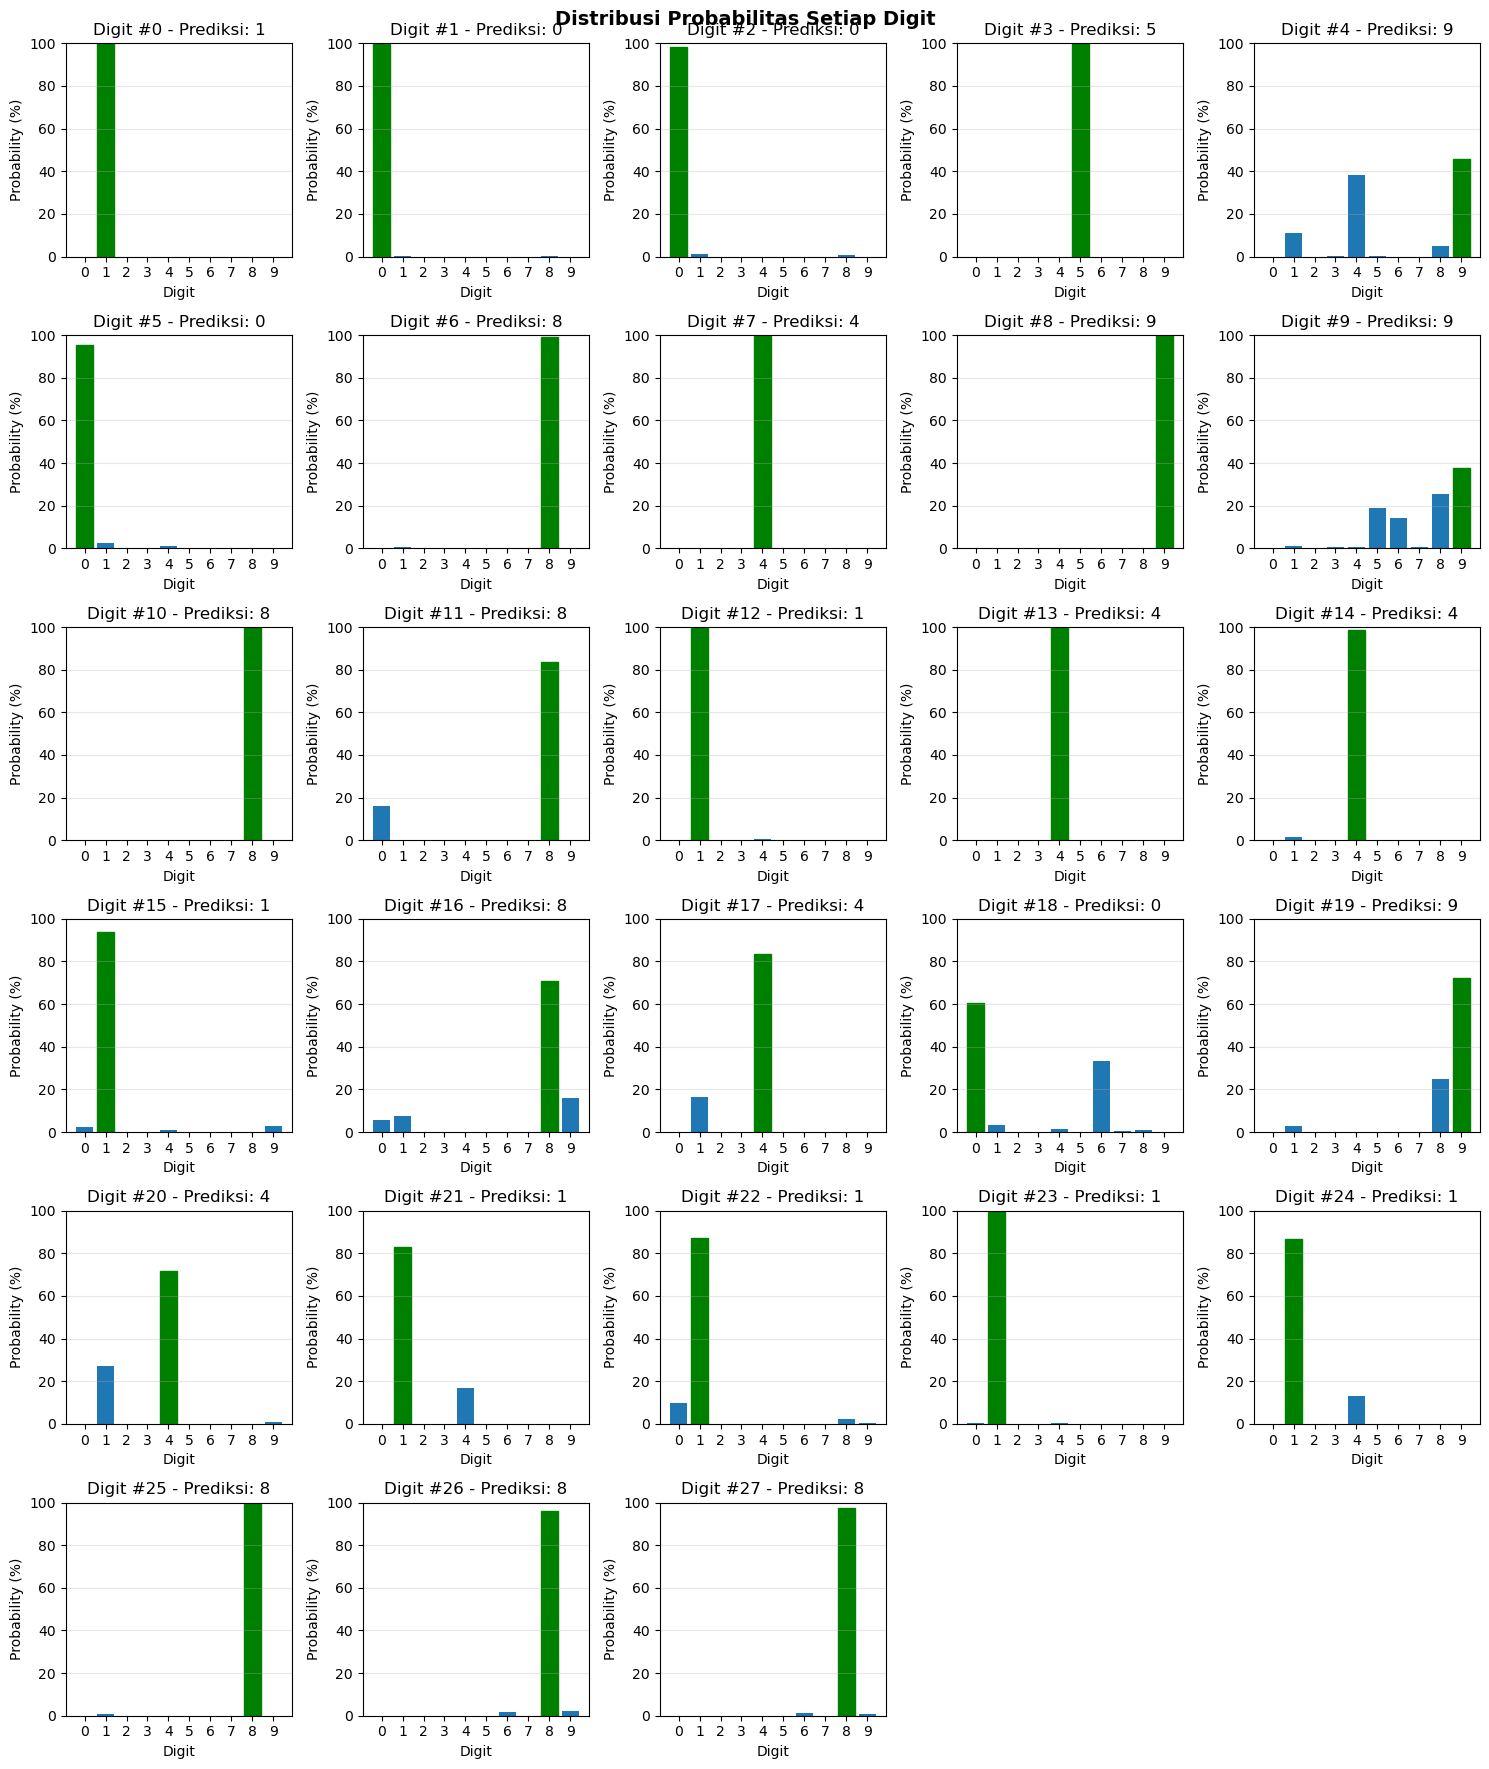

In [13]:
# Tampilkan bar chart probabilitas untuk setiap digit
if len(probabilities) > 0:
    num_digits = len(probabilities)
    cols = min(num_digits, 5)
    rows = (num_digits - 1) // 5 + 1
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
    
    if num_digits == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if num_digits > 1 else [axes]
    else:
        axes = axes.flatten()
    
    for i, (prob, pred) in enumerate(zip(probabilities, predictions)):
        if num_digits == 1:
            ax = axes[0]
        else:
            ax = axes[i]
            
        # Bar chart
        bars = ax.bar(range(10), prob * 100)
        
        # Highlight prediksi
        bars[pred].set_color('green')
        
        ax.set_xlabel('Digit')
        ax.set_ylabel('Probability (%)')
        ax.set_title(f'Digit #{i} - Prediksi: {pred}')
        ax.set_xticks(range(10))
        ax.set_ylim([0, 100])
        ax.grid(axis='y', alpha=0.3)
    
    # Hide unused subplots
    if num_digits > 1:
        for i in range(num_digits, len(axes)):
            axes[i].axis('off')
    
    plt.suptitle('Distribusi Probabilitas Setiap Digit', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Export Hasil

In [14]:
# # Export hasil ke file
# if len(predictions) > 0:
#     # Simpan gambar hasil
#     output_image_path = 'result_' + IMAGE_PATH
#     cv2.imwrite(output_image_path, img_result)
#     print(f"✓ Gambar hasil disimpan: {output_image_path}")
    
#     # Simpan hasil prediksi ke JSON
#     results = {
#         'image_path': IMAGE_PATH,
#         'model_type': MODEL_TYPE,
#         'detected_number': ''.join([str(p) for p in predictions]),
#         'digits': []
#     }
    
#     for i, (digit, pred, prob) in enumerate(zip(digits, predictions, probabilities)):
#         x, y, w, h = digit['bbox']
#         results['digits'].append({
#             'index': i,
#             'prediction': int(pred),
#             'confidence': float(prob[pred] * 100),
#             'bbox': {'x': int(x), 'y': int(y), 'width': int(w), 'height': int(h)},
#             'probabilities': {str(j): float(prob[j] * 100) for j in range(10)}
#         })
    
#     output_json_path = 'result_' + IMAGE_PATH.replace('.jpg', '.json').replace('.png', '.json')
#     with open(output_json_path, 'w') as f:
#         json.dump(results, f, indent=4)
    
#     print(f"✓ Hasil prediksi disimpan: {output_json_path}")
    
#     # Tampilkan summary
#     print("\n" + "="*60)
#     print("SUMMARY")
#     print("="*60)
#     print(f"Total digit terdeteksi: {len(predictions)}")
#     print(f"Angka yang terdeteksi: {results['detected_number']}")
#     print(f"Rata-rata confidence: {np.mean([prob[pred] * 100 for pred, prob in zip(predictions, probabilities)]):.2f}%")
#     print("="*60)
# else:
#     print("Tidak ada hasil untuk di-export!")

## Testing dengan Gambar Lain (Optional)

Untuk menguji dengan gambar lain, ubah nilai `IMAGE_PATH` di cell konfigurasi dan jalankan ulang semua cell.